## Modeling Data

- Import libraries
- create funciton to model data
- store data in df to compare metrics easily
- further stats 
- create visual

In [192]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import mglearn
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [193]:
# load in dictionary and assign numbers to categories
df = pd.read_csv('./data/final_df.csv', index_col =0)

In [194]:
df.isnull().sum()

title               0
cat_nums            0
combined            0
binary_text         0
stemmed_title       0
stemmed_combined    0
dtype: int64

In [247]:
# instaciate transofrmers with stop words left out
details = []
transformers = [TfidfVectorizer(stop_words= 'english'), CountVectorizer(stop_words= 'english')]

In [196]:
# function that models data and outputs relvant metrics
def model_gs(keyword, X, y, model, transformer_list, param):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   random_state =25,
                                                        stratify = y)
    # if model does not require data transormation
    if transformer_list == []:
        grid = GridSearchCV(model, param_grid=param, cv=5)
        grid.fit(X_train, y_train)
        details.append({
            'details': keyword,
            'model': model,
            'transformer': transformer,
            'accuracy_train': grid.score(X_train, y_train),
            'accuracy_test' :grid.score(X_test, y_test),
            'best_est': grid.best_estimator_
        })
   
    # for models that need transformation 
    else:
        for transformer in transformer_list:
            # instantiate pipeline
            pipe = Pipeline([
                ('trans',transformer),
                ('model', model)
                 ])
            
            # gridsearch over relevant parameters
            grid = GridSearchCV(pipe, param_grid=param, cv=5)
            grid.fit(X_train, y_train)
            
            #store score on test / train and best estimators
            details.append({
                'details': keyword,
                'model': model,
                'transformer': transformer,
                'accuracy_train': grid.score(X_train, y_train),
                'accuracy test' :grid.score(X_test, y_test),
                'best_est': grid.best_estimator_
            })
    return

In [239]:
# Logistic Regresion
X = df['title']
y = df['cat_nums']
log_params = {
        'trans__max_features': [5000,10000,14000],
        'trans__ngram_range' : [(1,1),(1,2),(1,3)],
        'model__C' : [.1,1,10]
        }
model_gs('logreg_title', X,y, LogisticRegression() , transformers, log_params)

In [237]:
df.head()

,title,cat_nums,combined,binary_text,stemmed_title,stemmed_combined
0,George Popadopoulos Judiciary Committee Transc...,0,George Popadopoulos Judiciary Committee Transc...,0,georg popadopoulo judiciari committe transcrip...,georg popadopoulo judiciari committe transcrip...
1,Scientists Will Spray Particles Into the Sky t...,0,Scientists Will Spray Particles Into the Sky t...,0,scientist will spray particl into the ski to b...,scientist will spray particl into the ski to b...
2,We Are Change confronted Joe Biden in 2007 abo...,0,We Are Change confronted Joe Biden in 2007 abo...,0,We are chang confront joe biden in about hi me...,We are chang confront joe biden in about hi me...
3,Jeff Sessions swats creepy Uncle Joe's hands away,0,Jeff Sessions swats creepy Uncle Joe's hands away,0,jeff session swat creepi uncl joe s hand away,jeff session swat creepi uncl joe s hand away
4,NXIVM cultist (🍕 gate) admits to enslaving wom...,0,NXIVM cultist (🍕 gate) admits to enslaving wom...,0,nxivm cultist gate admit to enslav woman for y...,nxivm cultist gate admit to enslav woman for y...


In [252]:
# KNN
X = df['stemmed_combined']
y = df['cat_nums']
knn_params = {
    'trans__max_features': [1000,5000,7500,10000],
#     'trans__ngram_range' : [(1,1),(1,2),(2,2)],
    'model__n_neighbors':[2,5,10,20]
}
model_gs('knn_stem_combined',X,y, KNeighborsClassifier(), transformers, knn_params)

In [266]:
# Multinomial Naive Bias
X = df['stemmed_combined']
y = df['cat_nums']
mnb_params = {
    'trans__max_features': [5000,7500,10000],
#     'trans__ngram_range' : [(1,1),(1,2),(2,2)],
    'model__alpha': [.1,.5,1,5]
}
model_gs('multiNB_stem_comb',X,y, MultinomialNB(), transformers, mnb_params)

In [220]:
# Decision Tree
X = df['title']
y = df['cat_nums']
dt_params = {
    'trans__max_features': [1000,2000,4500],
    'trans__ngram_range' : [(1,1),(1,2),(2,2)],
    'model__random_state': [42],
    'model__max_depth' : [125],
    'model__min_samples_split': [5,7,9]
    }
model_gs('dt_title_depth_125', X,y, DecisionTreeClassifier(), transformers, dt_params)

In [98]:
# Random Forest
X = df['title']
y = df['cat_nums']
rf_params = {
    'model__n_estimators': [10,20,50],
    'model__max_depth': [None, 3,4,5],
    'model__random_state': [42],
    'model__max_features': ['auto',]
            }
model_gs('rf_title', X,y, RandomForestClassifier(), transformers, rf_params)

In [274]:
# Bagging on Logistic Regression
X = df['stemmed_combined']
y = df['cat_nums']
model_gs('Logreg w/ bag stem_comb',X,y, BaggingClassifier(LogisticRegression()), transformers, {})

In [221]:
# Bagging on Multinomial
model_gs('multi NB w/ bag',X,y, BaggingClassifier(MultinomialNB()), transformers, {})

In [222]:
# Bagging on Decision Tree
model_gs('dt w/ bag',X,y, BaggingClassifier(DecisionTreeClassifier()), transformers, {})

In [223]:
# Bagging on Random Forest
model_gs('rf w/ bag',X,y, BaggingClassifier(RandomForestClassifier()), transformers, {})

In [275]:
# make it readable for evaluation
stats_dict = []
for i in details:
    stats_dict.append({
        'model': i['details'],
        'transformer': str(i['transformer'])[:15],
        'train_accuracy': i['accuracy_train'],
        'test_accuracy': i['accuracy test']
        })

stat_df = pd.DataFrame(stats_dict)
stat_df['dif'] = stat_df['train_accuracy'] - stat_df['test_accuracy'] 

In [276]:
stat_df

,model,test_accuracy,train_accuracy,transformer,dif
0,knn_title,0.841438,0.854725,TfidfVectorizer,0.013287
1,knn_title,0.718816,0.779267,CountVectorizer,0.060451
2,knn_combined,0.887949,0.913963,TfidfVectorizer,0.026014
3,knn_combined,0.623679,0.688293,CountVectorizer,0.064615
4,knn_stem_title,0.832981,0.888575,TfidfVectorizer,0.055594
5,knn_stem_title,0.731501,0.811707,CountVectorizer,0.080206
6,knn_stem_title,0.860465,0.892807,TfidfVectorizer,0.032342
7,knn_stem_title,0.716702,0.829337,CountVectorizer,0.112635
8,knn_stem_combined,0.892178,0.916784,TfidfVectorizer,0.024607
9,knn_stem_combined,0.615222,0.667137,CountVectorizer,0.051915


In [67]:
# Function we wrote together in class
def estimators(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    acuracy = (tp + tn) / (tp + fp + fn + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    print(f'Accuracy is: {acuracy}\nRecall is: {recall}\nPrecision is: {precision}\n')

In [281]:
# test train to measure metrics below outside of function
X_train, X_test, y_train, y_test =train_test_split(X,y,
                                                   random_state =25,
                                                        stratify = y)

In [283]:
# further metrics on top 3 models
mnb = details[17]['best_est']
y_preds = mnb.predict(X_test)
mnb_matrix = confusion_matrix(y_test, y_preds)
estimators(mnb_matrix)

Accuracy is: 0.9217758985200846
Recall is: 0.956
Precision is: 0.9018867924528302



In [72]:
lr = details[0]['best_est']
y_preds = lr.predict(X_test)
lr_matrix = confusion_matrix(y_test, y_preds).ravel()
estimators(lr_matrix)

Accuracy is: 0.8604651162790697
Recall is: 0.876
Precision is: 0.8622047244094488



In [262]:
knn = details[8]['best_est']
y_preds = knn.predict(X_test)
knn_matrix = confusion_matrix(y_test, y_preds)
estimators(knn_matrix)

Accuracy is: 0.7970401691331924
Recall is: 0.9
Precision is: 0.7601351351351351



In [288]:
vect = lr.named_steps['trans']
feature_names = np.array(vect.get_feature_names())
coef = lr.named_steps['model'].coef_

<Figure size 3000x2000 with 0 Axes>

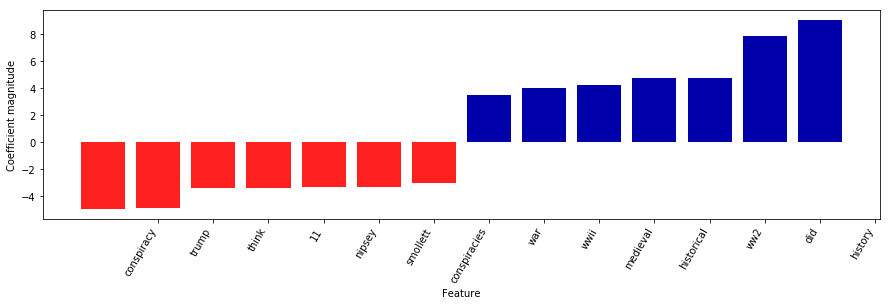

In [298]:
# plost of coeficients on Logreg / max & min 7
plt.figure(dpi=500)
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=7);